## Goal

하기 스크립트는, 일반 공정라인에서 나오는 Metric 데이터를 기준으로, 공정물에 대한 이상 탐지를 사전에 확인하는 방법을 확인하기 위하여 작성하였다. 

Metric에 대한 자세한 내용은 Blackbox상태로 제공되었음을 가정하고, 분석을 수행하는 것으로 진행한다. (현실에서는 당연히 현업과의 공조가 필수이다.)

[가정사항]

- Metric은 총, 10가지가 제시된다
- Metric값에는 초기치 및 계측 이상치가 포함되어 있을 수 있다
- Metric값에는 비어있는 값이 있을 수 있다

[공정순서에 따른 Metric]

 31 - 32 - 33 - 34 -35 - (42, 25, 77) - 193 (Validator)

In [7]:
import pandas as pd

In [10]:
tagvalues = pd.read_csv('./sample_iot_tag_ts_20230220.csv')


## 전처리

먼저, 개별 Metric에 대한 기본 통계값을 확인하고 이상한 부분을 확인한다.

In [12]:
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,7916,550.467465,1000.00,496.780071,1.21225,1000.000000,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,4365,34.033013,42.43,15.699804,0.00000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,7916,14.739654,0.00,16.021478,0.00000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,7916,16.452870,0.00,17.823753,0.00000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,7916,16.340852,0.00,17.680070,0.00000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,7916,15.525365,0.00,16.786623,0.00000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,7916,1.559250,0.00,1.665396,0.00000,3.450000,"[3.00999999, 2.970000029, 1.110000014, 0.0, 2...."
77,7916,182.274002,185.00,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,6501,54.011383,0.00,58.867856,0.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


자료 중에 이상한 부분을 살펴보면, 

- Tag 25 : max값, median값이 1000으로, 잘못된 값일 확률이 높다. 
- Tag 31~42 : median 값이 0인 것을 알 수 있다. 이 부분도 제거한다. 
- Tag 193 : 이 부분도, median 값이 0 이다. 이 부분도 제거한다.

In [24]:
tagvalues.loc[(tagvalues['TagIndex'] == 25) & (tagvalues['Val'] == 1000), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 31) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 32) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 33) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 34) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 35) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 42) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 193) & (tagvalues['Val'] == 0), ('Val')] = None


In [25]:
# 변경된 값을 확인해 보자. 
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,3564,1.543338,1.601750,0.138590,1.21225,1.707500,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,3650,40.699754,42.580002,4.834443,20.65000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,3654,31.931883,32.700001,2.652920,6.63000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,3665,35.536404,36.060001,2.814748,8.29000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,3665,35.294456,35.709999,2.471534,11.36000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,3665,33.533094,33.810001,2.169487,20.01000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,3717,3.320694,3.420000,0.238324,1.07000,3.450000,"[3.00999999, 2.970000029, 1.110000014, nan, 2...."
77,7916,182.274002,185.000000,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,2976,117.986559,118.000000,4.557143,1.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


보면 193번에 1값이 보이는 것을 확인된다. 1값은 잘못된 값으로 보고, 제거한다. 

In [26]:
tagvalues.loc[(tagvalues['TagIndex'] == 193) & (tagvalues['Val'] == 1), ('Val')] = None

In [27]:
# 변경된 값을 확인해 보자. 
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,3564,1.543338,1.601750,0.138590,1.21225,1.707500,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,3650,40.699754,42.580002,4.834443,20.65000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,3654,31.931883,32.700001,2.652920,6.63000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,3665,35.536404,36.060001,2.814748,8.29000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,3665,35.294456,35.709999,2.471534,11.36000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,3665,33.533094,33.810001,2.169487,20.01000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,3717,3.320694,3.420000,0.238324,1.07000,3.450000,"[3.00999999, 2.970000029, 1.110000014, nan, 2...."
77,7916,182.274002,185.000000,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,2975,118.025882,118.000000,4.021337,82.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


일단 그럴 듯하게 보인다. 
일단 위 내용을 토대로 Time Series Graph를 그려보자.

In [ ]:

import matplotlib.pyplot as plt

TagIndex
25     AxesSubplot(0.125,0.125;0.775x0.755)
31     AxesSubplot(0.125,0.125;0.775x0.755)
32     AxesSubplot(0.125,0.125;0.775x0.755)
33     AxesSubplot(0.125,0.125;0.775x0.755)
34     AxesSubplot(0.125,0.125;0.775x0.755)
35     AxesSubplot(0.125,0.125;0.775x0.755)
42     AxesSubplot(0.125,0.125;0.775x0.755)
77     AxesSubplot(0.125,0.125;0.775x0.755)
193    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Val, dtype: object

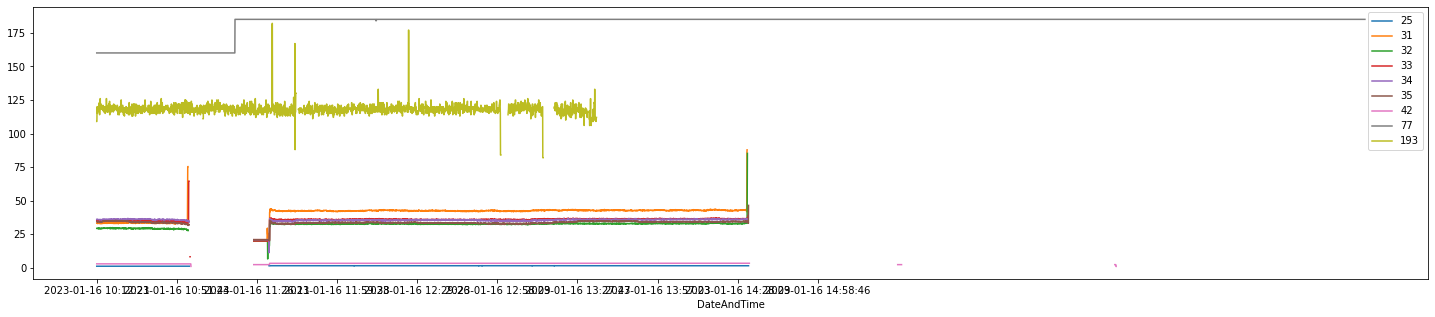

In [123]:

tagvalues.groupby('TagIndex', as_index='DateAndTime')['Val'].plot(figsize=(25,5), legend=True)

## 시계열간 Causality 분석

현재 개별 센서 또는 장비에서 출력되는 Sensor데이터는 해당 센서가 작업중인 공정물(Product)에 대한 시점 정보를 제공하지 않기 때문에, 
최종 점검 시점(193 번 메트릭)을 기준으로 개별 센서 데이터가 어는정도의 Leading Time을 가지고 있는지 계산할 필요가 있다. 

최종 결과를 판단하는 193번의 값의 경우, 개별 Metric값의 요동이 너무 심하므로, 전체적인 값을 Moving Average로 변경한다.

Moving Average를 구하기 위하여, resampling를 진행하기 전에, DatetimeIndex로 전환한다. 

In [106]:
indexed_values = tagvalues.set_index([pd.DatetimeIndex(tagvalues['DateAndTime']), 'TagIndex'])


한 화면에 이동 평균 값을 확인하기 위하여, subplot 객체를 생성하고, 이를 동일하게 이용하여, 한 화면에 도시한다.

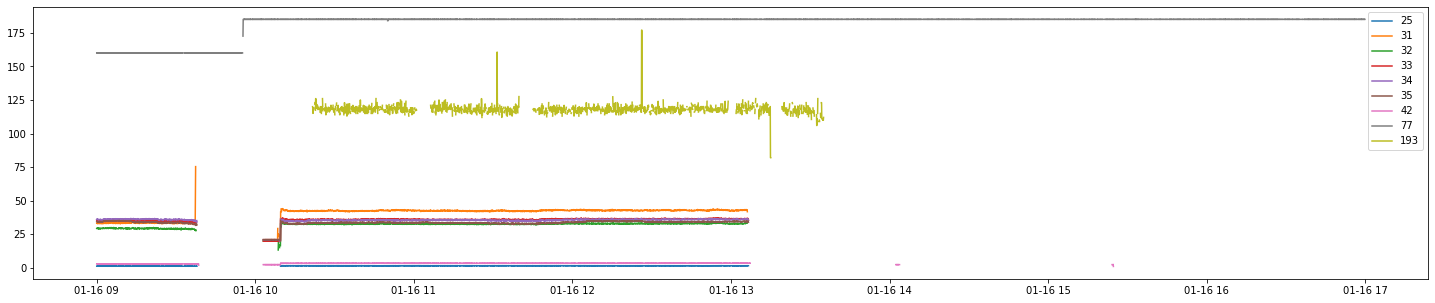

In [136]:
fig, ax = plt.subplots(figsize=(25,5))
ma5 = indexed_values.groupby('TagIndex')['Val'].resample('5S', level=0).agg(['mean'])
for key, grp in ma5.groupby('TagIndex'):
  ax.plot(grp.index.get_level_values(level=1),grp['mean'],label=key)
ax.legend()


정상상태를 기준으로, 인과관계를 확인해 보자.

Graph를 보면, 11시 50분에서 12시 25분까지 모든 Metric자료가 일반적인 형태를 보인다고 볼 수 있다. 

이를 다시 확인해 보면, 

In [142]:
ma5.loc[:, '2023-01-16 11:50:00':'2023-01-16 12:25:00']

Empty DataFrame
Columns: []
Index: [(25, 2023-01-16 09:00:00), (25, 2023-01-16 09:00:05), (25, 2023-01-16 09:00:10), (25, 2023-01-16 09:00:15), (25, 2023-01-16 09:00:20), (25, 2023-01-16 09:00:25), (25, 2023-01-16 09:00:30), (25, 2023-01-16 09:00:35), (25, 2023-01-16 09:00:40), (25, 2023-01-16 09:00:45), (25, 2023-01-16 09:00:50), (25, 2023-01-16 09:00:55), (25, 2023-01-16 09:01:00), (25, 2023-01-16 09:01:05), (25, 2023-01-16 09:01:10), (25, 2023-01-16 09:01:15), (25, 2023-01-16 09:01:20), (25, 2023-01-16 09:01:25), (25, 2023-01-16 09:01:30), (25, 2023-01-16 09:01:35), (25, 2023-01-16 09:01:40), (25, 2023-01-16 09:01:45), (25, 2023-01-16 09:01:50), (25, 2023-01-16 09:01:55), (25, 2023-01-16 09:02:00), (25, 2023-01-16 09:02:05), (25, 2023-01-16 09:02:10), (25, 2023-01-16 09:02:15), (25, 2023-01-16 09:02:20), (25, 2023-01-16 09:02:25), (25, 2023-01-16 09:02:30), (25, 2023-01-16 09:02:35), (25, 2023-01-16 09:02:40), (25, 2023-01-16 09:02:45), (25, 2023-01-16 09:02:50), (25, 2023-01-16 09:02:55), (25, 2023-01-16 09:03:00), (25, 2023-01-16 09:03:05), (25, 2023-01-16 09:03:10), (25, 2023-01-16 09:03:15), (25, 2023-01-16 09:03:20), (25, 2023-01-16 09:03:25), (25, 2023-01-16 09:03:30), (25, 2023-01-16 09:03:35), (25, 2023-01-16 09:03:40), (25, 2023-01-16 09:03:45), (25, 2023-01-16 09:03:50), (25, 2023-01-16 09:03:55), (25, 2023-01-16 09:04:00), (25, 2023-01-16 09:04:05), (25, 2023-01-16 09:04:10), (25, 2023-01-16 09:04:15), (25, 2023-01-16 09:04:20), (25, 2023-01-16 09:04:25), (25, 2023-01-16 09:04:30), (25, 2023-01-16 09:04:35), (25, 2023-01-16 09:04:40), (25, 2023-01-16 09:04:45), (25, 2023-01-16 09:04:50), (25, 2023-01-16 09:04:55), (25, 2023-01-16 09:05:00), (25, 2023-01-16 09:05:05), (25, 2023-01-16 09:05:10), (25, 2023-01-16 09:05:15), (25, 2023-01-16 09:05:20), (25, 2023-01-16 09:05:25), (25, 2023-01-16 09:05:30), (25, 2023-01-16 09:05:35), (25, 2023-01-16 09:05:40), (25, 2023-01-16 09:05:45), (25, 2023-01-16 09:05:50), (25, 2023-01-16 09:05:55), (25, 2023-01-16 09:06:00), (25, 2023-01-16 09:06:05), (25, 2023-01-16 09:06:10), (25, 2023-01-16 09:06:15), (25, 2023-01-16 09:06:20), (25, 2023-01-16 09:06:25), (25, 2023-01-16 09:06:30), (25, 2023-01-16 09:06:35), (25, 2023-01-16 09:06:40), (25, 2023-01-16 09:06:45), (25, 2023-01-16 09:06:50), (25, 2023-01-16 09:06:55), (25, 2023-01-16 09:07:00), (25, 2023-01-16 09:07:05), (25, 2023-01-16 09:07:10), (25, 2023-01-16 09:07:15), (25, 2023-01-16 09:07:20), (25, 2023-01-16 09:07:25), (25, 2023-01-16 09:07:30), (25, 2023-01-16 09:07:35), (25, 2023-01-16 09:07:40), (25, 2023-01-16 09:07:45), (25, 2023-01-16 09:07:50), (25, 2023-01-16 09:07:55), (25, 2023-01-16 09:08:00), (25, 2023-01-16 09:08:05), (25, 2023-01-16 09:08:10), (25, 2023-01-16 09:08:15), ...]

[48524 rows x 0 columns]